## Introduction: Manual Feature Engineering

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

### Example: Counts of a client's previous loans

In [2]:
from pathlib import Path

data_dir = Path('C:/Users/sinjy/jupyter_notebook/datasets/kaggle_datasets/Home-Credit-Default-Risk_dataset')

bureau = pd.read_csv(data_dir / 'bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [3]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [4]:
train = pd.read_csv(data_dir / 'application_train.csv')
train = train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Assesing Usefulness of New Variable with r value

In [5]:
def kde_target(var_name, df):
    corr = df['TARGET'].corr(df[var_name])
    
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize=(12, 6))
    
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label='TARGET=0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label='TARGET=1')
    
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()
    
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    print('Median value for loan that was not repaid = %0.4f' % (avg_not_repaid))
    print('Median value for loan that was repaid = %0.4f' % (avg_repaid))

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid = 0.5460


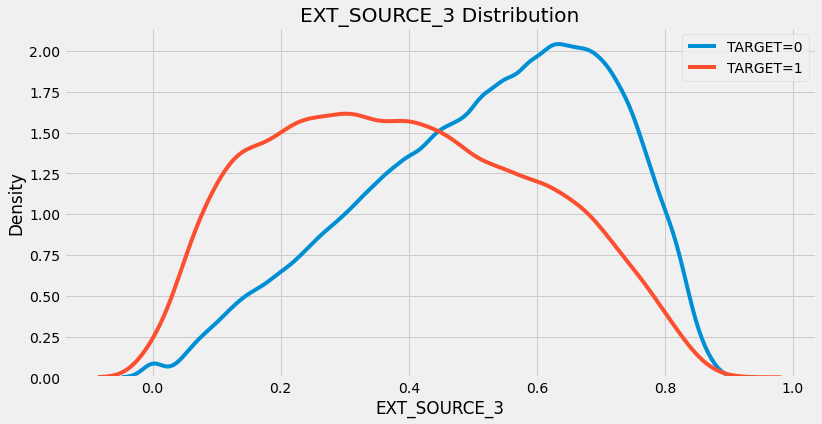

In [6]:
kde_target('EXT_SOURCE_3', train)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid = 4.0000


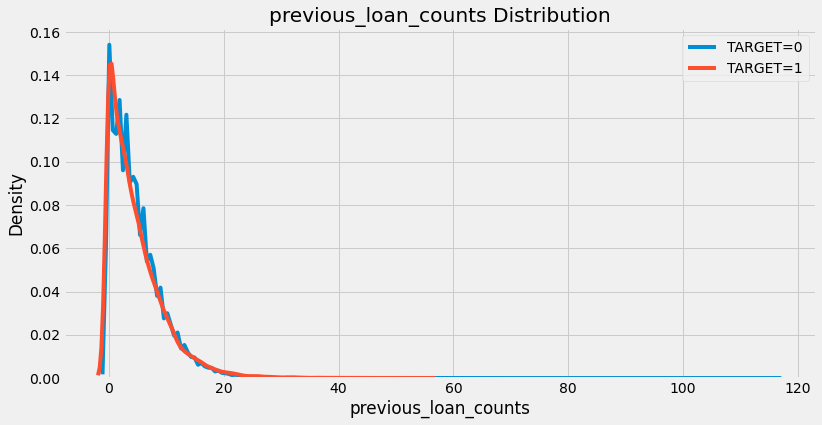

In [7]:
kde_target('previous_loan_counts', train)

### Aggregating Numeric Columns

In [8]:
bureau_agg = bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index=False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

In [9]:
columns = ['SK_ID_CURR']

for var in bureau_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':
        for stat in bureau_agg.columns.levels[1][:-1]:
            columns.append('bureau_%s_%s' % (var, stat))

In [10]:
columns

['SK_ID_CURR',
 'bureau_DAYS_CREDIT_count',
 'bureau_DAYS_CREDIT_mean',
 'bureau_DAYS_CREDIT_max',
 'bureau_DAYS_CREDIT_min',
 'bureau_DAYS_CREDIT_sum',
 'bureau_CREDIT_DAY_OVERDUE_count',
 'bureau_CREDIT_DAY_OVERDUE_mean',
 'bureau_CREDIT_DAY_OVERDUE_max',
 'bureau_CREDIT_DAY_OVERDUE_min',
 'bureau_CREDIT_DAY_OVERDUE_sum',
 'bureau_DAYS_CREDIT_ENDDATE_count',
 'bureau_DAYS_CREDIT_ENDDATE_mean',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'bureau_DAYS_CREDIT_ENDDATE_min',
 'bureau_DAYS_CREDIT_ENDDATE_sum',
 'bureau_DAYS_ENDDATE_FACT_count',
 'bureau_DAYS_ENDDATE_FACT_mean',
 'bureau_DAYS_ENDDATE_FACT_max',
 'bureau_DAYS_ENDDATE_FACT_min',
 'bureau_DAYS_ENDDATE_FACT_sum',
 'bureau_AMT_CREDIT_MAX_OVERDUE_count',
 'bureau_AMT_CREDIT_MAX_OVERDUE_mean',
 'bureau_AMT_CREDIT_MAX_OVERDUE_max',
 'bureau_AMT_CREDIT_MAX_OVERDUE_min',
 'bureau_AMT_CREDIT_MAX_OVERDUE_sum',
 'bureau_CNT_CREDIT_PROLONG_count',
 'bureau_CNT_CREDIT_PROLONG_mean',
 'bureau_CNT_CREDIT_PROLONG_max',
 'bureau_CNT_CREDIT_PROLONG_mi

In [11]:
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [12]:
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


In [13]:
new_corrs = []

for col in columns:
    corr = train['TARGET'].corr(train[col])
    new_corrs.append((col, corr))

In [14]:
new_corrs = sorted(new_corrs, key=lambda x: abs(x[1]), reverse=True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998122),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968668),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392113),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102051),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758661),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973095),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111589),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483543),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730176),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484684),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306004),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329046),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03428110992161599),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325547)]

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid = -1067.0000


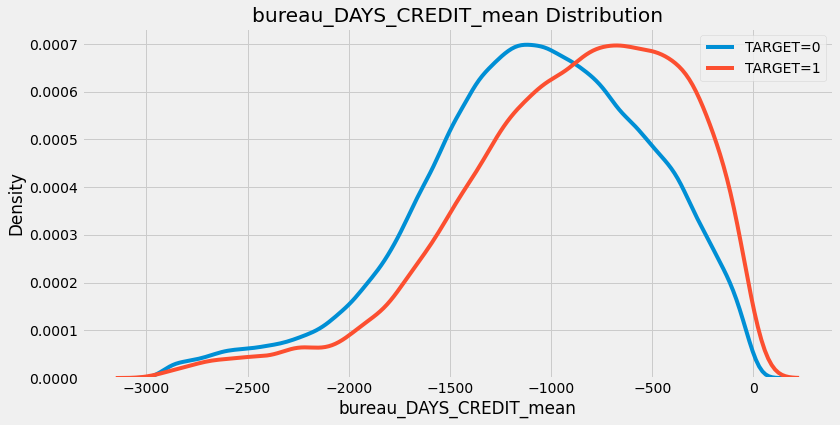

In [15]:
kde_target('bureau_DAYS_CREDIT_mean', train)

### Function for Numeric Aggregations

In [16]:
def agg_numeric(df, group_var, df_name):
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns=col)
    
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    columns = [group_var]
    
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    return agg

In [17]:
bureau_agg_new = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [18]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [19]:
def target_corrs(df):
    corrs = []
    for col in df.columns:
        print(col)
        if col != 'TARGET':
            corr = df['TARGET'].corr(df[col])
            corrs.append((col, corr))
    corrs = sorted(corrs, key=lambda x: abs(x[1]), reverse=True)
    return corrs

### Categorical Variables

In [20]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [21]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

In [22]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [23]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [24]:
group_var = 'SK_ID_CURR'
columns = []

for var in categorical_grouped.columns.levels[0]:
    if var != group_var:
        for stat in ['count', 'count_norm']:
            columns.append('%s_%s' % (var, stat))
            
categorical_grouped.columns = columns
categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [25]:
train = train.merge(categorical_grouped, left_on='SK_ID_CURR', 
                    right_index=True, how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
train.shape

(307511, 229)

In [27]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
        
    categorical.columns = column_names
    return categorical

In [29]:
bureau_counts = count_categorical(bureau, group_var='SK_ID_CURR', df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [30]:
bureau_balance = pd.read_csv(data_dir / 'bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [31]:
bureau_balance_counts = count_categorical(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [32]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [33]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True, left_on='SK_ID_BUREAU', how='outer')
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on='SK_ID_BUREAU', how='left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [34]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


## Putting the Functions Together

In [35]:
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, 
bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

10457

In [36]:
train = pd.read_csv(data_dir / 'application_train.csv')
bureau = pd.read_csv(data_dir / 'bureau.csv')
bureau_balance = pd.read_csv(data_dir / 'bureau_balance.csv')

In [37]:
bureau_counts = count_categorical(bureau, group_var='SK_ID_CURR', df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [38]:
bureau_agg = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), 
                         group_var='SK_ID_CURR', df_name='bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [39]:
bureau_balance_counts = count_categorical(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [40]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [41]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True, left_on='SK_ID_BUREAU', how='outer')
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on='SK_ID_BUREAU', how='left')

bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='client')

### Insert Computed Features into Training Data

In [42]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [43]:
train = train.merge(bureau_counts, on='SK_ID_CURR', how='left')
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train = train.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')

In [44]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


## Feature Engineering Outcomes

### Missing Values

In [51]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0
    ].sort_values('% of Total Values', ascending=False).round(1)
    print('Your selected dataframe has ' + str(df.shape[1]) + " columns.\n"
         "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    return mis_val_table_ren_columns

In [52]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


In [53]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

### Calculate Information for Testing Data

In [55]:
test = pd.read_csv(data_dir / 'application_test.csv')
test = test.merge(bureau_counts, on='SK_ID_CURR', how='left')
test = test.merge(bureau_agg, on='SK_ID_CURR', how='left')
test = test.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')

In [57]:
print('Shape of Testing Data: test.shape: ', test.shape)

Shape of Testing Data: test.shape:  (48744, 332)


In [58]:
train_labels = train['TARGET']
train, test = train.align(test, join='inner', axis=1)
train['TARGET'] = train_labels

In [59]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


In [60]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [61]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [62]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [63]:
train = train.drop(columns=missing_columns)
test = test.drop(columns=missing_columns)

In [64]:
train.to_csv(data_dir / 'train_bureau_raw.csv', index=False)
test.to_csv(data_dir / 'test_bureau_raw.csv', index=False)

### Correlations

In [65]:
corrs = train.corr()

In [66]:
corrs = corrs.sort_values('TARGET', ascending=False)
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [67]:
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid = 0.3636


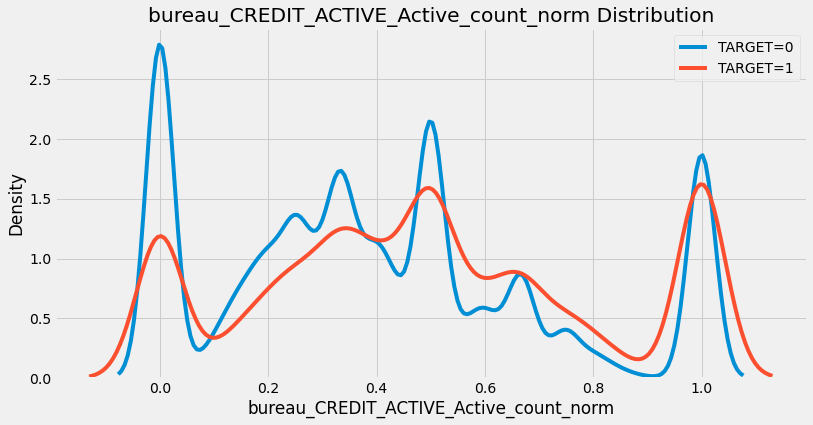

In [74]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

In [75]:
threshold = 0.8
above_threshold_vars = {}

for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [78]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
                
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


In [79]:
train_corrs_removed = train.drop(columns=cols_to_remove)
test_corrs_removed = test.drop(columns=cols_to_remove)
print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [80]:
train_corrs_removed.to_csv(data_dir / 'train_bureau_corrs_removed.csv', index=False)
test_corrs_removed.to_csv(data_dir / 'test_bureau_corrs_removed.csv', index=False)

## Modeling